In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

/tmp/ipykernel_260234/1608063908.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_csv('data/final.csv')

In [3]:
df.head()

Username            Date  Followers               Source  \
0  CaeruleusCalva  4. August 2021  1088.0     Twitter for Android   
1  kambanellas     4. August 2021  316.0      Twitter for Android   
2  em56464         4. August 2021  116.0      Twitter Web App       
3  zetakosmatougk  4. August 2021  2955.0     Twitter for Android   
4  PeterParker_84  4. August 2021  149.0      Twitter Web App       

                Location  \
0  Not So Ancient Greece   
1  Cyprus                  
2  NaN                     
3  greece                  
4  Timbuktu Κάτω Αχαίας    

                                                                                                                                                                                                                                                             Tweet  
0  Όπως λένε και οι καθηγητές ΩΡΛ: Τα ανεμβολίαστα ζώα πεθαίνουν από #κορωνοϊό. Τα εμβολιασμένα ζώα δεν πεθαίνουν από κορωνοϊό.\nΣυμπέρασμα: Δεν υπάρχει #εμβόλιο για το να μην είναι κανείς ζώο (οργανισμός από ζωϊκά κύτταρα τα οποία ο κορωνοϊός έχει στόχους).  
1  @percentcrumpet @themist7 @Dr_kypri Δυστυχώς τα δεδομένα δεν αλλάζουν... είτε σου αρέσει είτε όχι. \nΔε θες εμβόλιο πρόβλημα σου. Να μη θέλεις να πιστέψεις δεδομένα επειδή έτσι σου κάπνισε σε κάνει προβληματικό.  \nΣόρρυ αλλά δεν υπάρχει κάτι άλλο.         
2  RT @Gerasim73424653: Χειροκροτούν τους πυροσβέστες μέχρι να σβήσει η φωτιά,  μετά κατάρες κ απειλές  απόλυσης αν δεν κάνουν το εμβόλιο.                                                                                                                          
3  RT @Faklana38: Έχετε μισό λεπτό να σας μιλήσω για το εμβόλιο της Pfizer; #Μητσοτακη_γαμιεσαι #μητσοτακη_παραιτησου #Μητσοτακη_καθαρμα #φωτι…                                                                                                                     
4  Σκέψου ούτε οι ίδιοι δεν εμπιστεύονται το εμβόλιο τους. https://t.co/bW5Ina3iFR

Μετατρέπουμε τα tweets σε μικρά γράμματα

In [4]:
to_lowercase = lambda x : (str(x).lower())
df['Tweet'] = df.Tweet.apply(to_lowercase)

Αφαιρούμε όλους τους μη ελληνικούς χαρακτήρες από τα tweets.

In [5]:
df['Tweet'] = df['Tweet'].str.replace(r'[a-zA-Z0-9]', '', regex=True)

In [6]:
df['Tweet']

0        όπως λένε και οι καθηγητές ωρλ: τα ανεμβολίαστα ζώα πεθαίνουν από #κορωνοϊό. τα εμβολιασμένα ζώα δεν πεθαίνουν από κορωνοϊό.\nσυμπέρασμα: δεν υπάρχει #εμβόλιο για το να μην είναι κανείς ζώο (οργανισμός από ζωϊκά κύτταρα τα οποία ο κορωνοϊός έχει στόχους).                            
1        @ @ @_ δυστυχώς τα δεδομένα δεν αλλάζουν... είτε σου αρέσει είτε όχι. \nδε θες εμβόλιο πρόβλημα σου. να μη θέλεις να πιστέψεις δεδομένα επειδή έτσι σου κάπνισε σε κάνει προβληματικό.  \nσόρρυ αλλά δεν υπάρχει κάτι άλλο.                                                                
2         @: χειροκροτούν τους πυροσβέστες μέχρι να σβήσει η φωτιά,  μετά κατάρες κ απειλές  απόλυσης αν δεν κάνουν το εμβόλιο.                                                                                                                                                                     
3         @: έχετε μισό λεπτό να σας μιλήσω για το εμβόλιο της ; #μητσοτακη_γαμιεσαι #μητσοτακη_παραιτησου #μητσοτακη_καθ

In [7]:
df['Tweet'] = df['Tweet'].str.replace('@_"^[a-zA-Z0-9]', '', regex=True)

In [8]:
def delete_tonous(df, column_to_process, processed_column='Tweet'):
    
    if (processed_column != column_to_process):
        df[processed_column] = df[column_to_process]  # create new column

    # replace greek hyphend letters
    replacements = {processed_column: {'ά': 'α', 'έ': 'ε', 'ή': 'η', 'ί': 'ι', 'ό': 'ο', 'ύ': 'υ', 'ώ': 'ω', 'ϊ': 'ι'}}
    df.replace(replacements, regex=True, inplace=True)
    
    return (df)

Αφαιρούμε τους τόνους καθώς και τα διαλυτικά από τα tweets. Τα διαλυτικά είναι σπάνια στην ελληνική γλώσσα, ωστόσο μια πολύ συχνή λέξη στα δεδομένα είναι η λέξη κορονοϊός η οποία συναντάται πολύ συχνά στα δεδομένα επομένως είναι απαραίτητο να αφαιρεθεί.

In [9]:
delete_tonous(df=df, column_to_process='Tweet', processed_column='Tweet').head(2)

Username            Date  Followers               Source  \
0  CaeruleusCalva  4. August 2021  1088.0     Twitter for Android   
1  kambanellas     4. August 2021  316.0      Twitter for Android   

                Location  \
0  Not So Ancient Greece   
1  Cyprus                  

                                                                                                                                                                                                                                                             Tweet  
0  οπως λενε και οι καθηγητες ωρλ: τα ανεμβολιαστα ζωα πεθαινουν απο #κορωνοιο. τα εμβολιασμενα ζωα δεν πεθαινουν απο κορωνοιο.\nσυμπερασμα: δεν υπαρχει #εμβολιο για το να μην ειναι κανεις ζωο (οργανισμος απο ζωικα κυτταρα τα οποια ο κορωνοιος εχει στοχους).  
1  @ @ @_ δυστυχως τα δεδομενα δεν αλλαζουν... ειτε σου αρεσει ειτε οχι. \nδε θες εμβολιο προβλημα σου. να μη θελεις να πιστεψεις δεδομενα επειδη ετσι σου καπνισε σε κανει προβληματικο.  \nσορρυ αλλα δεν υπαρχει κατι αλλο.

Αφαιρούμε όλα τα links από τα tweets.

In [10]:
remove_url = lambda x: re.sub('https\S+', '', str(x))
df['Tweet'] = df.Tweet.apply(remove_url)

Αφαιρούμε όλα τα σημεία στήξης από τα δεδομένα

In [11]:
remove_puncs = lambda x: x.translate(str.maketrans('','',string.punctuation))
df['Tweet'] = df.Tweet.apply(remove_puncs)
df['Tweet']

0        οπως λενε και οι καθηγητες ωρλ τα ανεμβολιαστα ζωα πεθαινουν απο κορωνοιο τα εμβολιασμενα ζωα δεν πεθαινουν απο κορωνοιο\nσυμπερασμα δεν υπαρχει εμβολιο για το να μην ειναι κανεις ζωο οργανισμος απο ζωικα κυτταρα τα οποια ο κορωνοιος εχει στοχους                              
1           δυστυχως τα δεδομενα δεν αλλαζουν ειτε σου αρεσει ειτε οχι \nδε θες εμβολιο προβλημα σου να μη θελεις να πιστεψεις δεδομενα επειδη ετσι σου καπνισε σε κανει προβληματικο  \nσορρυ αλλα δεν υπαρχει κατι αλλο                                                                    
2          χειροκροτουν τους πυροσβεστες μεχρι να σβησει η φωτια  μετα καταρες κ απειλες  απολυσης αν δεν κανουν το εμβολιο                                                                                                                                                                  
3          εχετε μισο λεπτο να σας μιλησω για το εμβολιο της  μητσοτακηγαμιεσαι μητσοτακηπαραιτησου μητσοτακηκαθαρμα φωτι…                    

Στη στήλη Location υπάρχουν πολλές κενές εγγραφές. Τις αντικαθηστούμε με 'prefer not to say' προκειμένου να σβήσουμε στη συνέχεια τις κενές εγγραφές από τη στήλη Tweet. Aφαιρούμε τη συνέχεια τα επαναλαμβανόμενα tweets καθώς και τις κενές εγγραφές	

In [12]:
df["Location"].fillna('prefer not to say', inplace = True)

Επιβεβαιώνουμε την αλλαγή

In [13]:
df[df['Location'] == "prefer not to say"].head()

Username            Date  Followers               Source  \
2   em56464        4. August 2021  116.0      Twitter Web App       
5   EvgenTzavaras  4. August 2021  1813.0     Twitter for Android   
8   TheW0lfpup     4. August 2021  2988.0     Twitter for Android   
11  Lunaticus_9    4. August 2021  41.0       Twitter Web App       
12  malaganas      4. August 2021  17.0       Twitter for Android   

             Location  \
2   prefer not to say   
5   prefer not to say   
8   prefer not to say   
11  prefer not to say   
12  prefer not to say   

                                                                                                                                                                                                                          Tweet  
2     χειροκροτουν τους πυροσβεστες μεχρι να σβησει η φωτια  μετα καταρες κ απειλες  απολυσης αν δεν κανουν το εμβολιο                                                                                                           
5     ημαρτον ξεστραβωθειτε ειστε και πιτσιρικαδες ασχημο το κολλημα στην εγκεφαλικη σκατιλα απο τοσο νεαροι\n το εμβολιο\nμαντεψε με υπερβλακιτους πολλαπλασιους των σημερινων ποτε ηρθε ελλαδα και ποιοο θαρραλεοι το κανανε   
8    α δηλαδη για το εμβολιο εχει μια σταση γιατι ειναι γιατρος ενω για ολες τις μπαρουφες που ανεβαζει δεν ειναι\nαγορι μου δεν εισαι ουτε για τα πανηγυρια                                                                     
11   τωρα νομιζεις οτι εχεις εμβολιο  γελανε και οι πετρες  καλη προστασια σου ευχομαι                                                                                                                                           
12  εσεις κυριε το εχετε κανει το εμβολιο\n\n\nλιμνηευβοιας φωτιαβαρυμπομπη μητσοτακηγαμιεσαι

In [14]:
df['Tweet'] = df.Tweet.drop_duplicates()

In [15]:
df = df.dropna()

Βλέπουμε αν υπάρχουν τυχόν υπολοιπόμενες κενές εγγραφές στη στήλη Τweet

In [16]:
df['Tweet'].isna().sum()

0

Μετράμε το μέσο μάκρος των Tweets μετά την αφαίρεση των links και των mentions.

In [17]:
df['length'] = df['Tweet'].apply(len)

In [18]:
#Save and load new file
# df.to_csv('modified_with_length.csv')

In [19]:
df = pd.read_csv('data/modified_with_length.csv')

Bλέπουμε τα στατιστικά στοιχεία του μάκρους των tweets.

In [20]:
df.length.describe()

count    25339.000000
mean     140.053633  
std      77.204873   
min      1.000000    
25%      75.000000   
50%      126.000000  
75%      208.000000  
max      282.000000  
Name: length, dtype: float64

In [21]:
#Average tweet
df[df['length'] == 140]['Tweet'].iloc[0]

'κορωνοιος  πανδημια κρουσματα  διασωληνωμενοι  εξελθοντες απο μεθ  απωλειες  τεστ  κορονοιος  δεικτηςθετικοτητας  εμβολιο  εξιτηρια  ανοσια'

In [22]:
#Longest tweet
df[df['length'] == 282]['Tweet'].iloc[0]

'μπορεις να εκφερεις αποψη εννοειται αλλα διαβασε πρωτα αυτο το εμβολιο που λες ηταν κατι βιαστικο συγκριτικα με το πως πρεπει να βγαινει ενα εμβολιο και σε μια πανδημια ειναι λογικο και επομενο να υπαρξουν μεταλλαξεις το εμβολιο το βιαστικο δεν μπορει να μαντεψει τις μεταλλαξεις'

In [23]:
#tweet with 1 characters
df[df['length'] == 1]

Unnamed: 0         Username            Date  Followers  \
12252  12252       uU1anaBa5tHy1d1  18. Jul. 2021   253.0       
14794  14794       the_most_ironic  19. Jul. 2021   192.0       
15815  15815       zanoulitsa       20. Jul. 2021   794.0       
22586  22586       Dreamon_tweet    29. July 2021   483.0       
24648  24648       FrantseskaA      1. August 2021  555.0       

                    Source                   Location Tweet  length  \
12252  Twitter for Android  prefer not to say          😏     1        
14794  Twitter Web App      Greece                     👇     1        
15815  Twitter for Android  Crete                      🤣     1        
22586  Twitter for Android  Kavala, Macedonia, Greece  😄     1        
24648  Twitter for Android  prefer not to say          💖     1        

      Tweet_without_stopwords Translated Tokens  
12252  😏                       😏          []     
14794  👇                       👇          []     
15815  🤣                       🤣          []     
22586  😄                       😄          []     
24648  💖                       💖          []

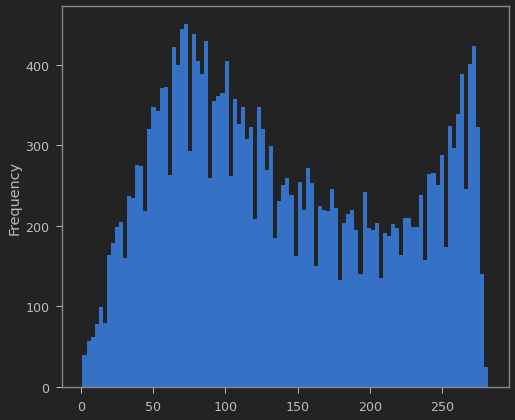

In [27]:
#Βλέπουμε τη κατανομή του μήκους των tweets
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
df['length'].plot(bins=100, kind='hist');

### Removing Stopwords

Είναι πολύ σημαντικό να αφαιρέσουμε τις stopwords γιατί αποτελούν τις λέξεις που επαναλαμβάνονται συνεχώς και δεν δίνουν κάποιο νόημα στη φράση. Ενημερώνουμε το πακέτο της nltk με λέξεις που εντοπίστηκαν στα δεδομένα μας και θα ήταν καλό να αφαιρεθούν.

In [28]:
from nltk.corpus import stopwords

In [29]:
more_words = ['/', 'covid19greece',  'AstraZeneca', 'νδ', 'μητσοτακη', 'αδωνις', 'pfizerleak', 'αδωνις', 'ypyggr', 'embolio', 'εμβολιο', 'χαχαχα', 'politisnews', 'αν', 'astrazeneca', 'astra', 'zeneca', 'phizer', 'α', 'ε', 'ν', 'via', 'tι', 'marka149133376', 'ο', 'χ', 'length', 'rt', 'political', 'fediuld76', 'πιο', '2', 'ποθενεσχες', 'frq', 'COVID19greece', 'COVID19', 'Covid19', 'Marka149133376', 'covid19gr', 'covid19greece', 'covid', 'εγω', 'εσυ', 'adonisgeorgiadi', 'κανω','αλλο', 'κανεις', 'γιατι', 'αφου', 'σαν', 'εχεις', 'πολυ', 'κατι', 'πριν', 'ολα', 'εχουν', 'κανουν', 'εχει', 'έχουν', 'κανουν', 'κανει', 'οπως', 'μια', 'ενα', 'amp', 'στις', 'στα', 'ιο', 'στους', 'covid19', '–', 'marka149133376', 'εδω', 'της', 'τους', 'μας', 'ρε', 'ουτε', 'ηταν', 'εχω', 'οταν', 'τη', 'σου', 'μου', 'σας']
stop_words = set(stopwords.words('greek'))
stop_words.update(more_words)
stop_words

{'/',
 '2',
 'AstraZeneca',
 'COVID19',
 'COVID19greece',
 'Covid19',
 'Marka149133376',
 'adonisgeorgiadi',
 'amp',
 'astra',
 'astrazeneca',
 'covid',
 'covid19',
 'covid19gr',
 'covid19greece',
 'embolio',
 'fediuld76',
 'frq',
 'length',
 'marka149133376',
 'pfizerleak',
 'phizer',
 'political',
 'politisnews',
 'rt',
 'tι',
 'via',
 'ypyggr',
 'zeneca',
 'έχουν',
 'α',
 'αδωνις',
 'αλλα',
 'αλλο',
 'αν',
 'αντι',
 'απο',
 'αυτα',
 'αυτεσ',
 'αυτη',
 'αυτο',
 'αυτοι',
 'αυτοσ',
 'αυτουσ',
 'αυτων',
 'αφου',
 'αἱ',
 'αἳ',
 'αἵ',
 'αὐτόσ',
 'αὐτὸς',
 'αὖ',
 'γάρ',
 'γα',
 'γα^',
 'γε',
 'για',
 'γιατι',
 'γοῦν',
 'γὰρ',
 "δ'",
 'δέ',
 'δή',
 'δαί',
 'δαίσ',
 'δαὶ',
 'δαὶς',
 'δε',
 'δεν',
 "δι'",
 'διά',
 'διὰ',
 'δὲ',
 'δὴ',
 'δ’',
 'ε',
 'εαν',
 'εγω',
 'εδω',
 'ειμαι',
 'ειμαστε',
 'ειναι',
 'εισαι',
 'ειστε',
 'εκεινα',
 'εκεινεσ',
 'εκεινη',
 'εκεινο',
 'εκεινοι',
 'εκεινοσ',
 'εκεινουσ',
 'εκεινων',
 'εμβολιο',
 'ενα',
 'ενω',
 'επ',
 'επι',
 'εσυ',
 'εχει',
 'εχεις',
 'εχουν',

In [30]:
remove_words = lambda x : ' '.join([word for word in str(x).split() if word not in stop_words])
df['Tweet_without_stopwords'] = df.Tweet.apply(remove_words)
df['Tweet_without_stopwords']

0        λενε καθηγητες ωρλ ανεμβολιαστα ζωα πεθαινουν κορωνοιο εμβολιασμενα ζωα πεθαινουν κορωνοιο συμπερασμα υπαρχει ζωο οργανισμος ζωικα κυτταρα οποια κορωνοιος στοχους
1        δυστυχως δεδομενα αλλαζουν ειτε αρεσει ειτε οχι θες προβλημα θελεις πιστεψεις δεδομενα επειδη ετσι καπνισε προβληματικο σορρυ υπαρχει                             
2        χειροκροτουν πυροσβεστες μεχρι σβησει φωτια καταρες απειλες απολυσης                                                                                              
3        εχετε μισο λεπτο μιλησω μητσοτακηγαμιεσαι μητσοτακηπαραιτησου μητσοτακηκαθαρμα φωτι…                                                                              
4        σκεψου ιδιοι εμπιστευονται                                                                                                                                        
                    ...                                                                                                                     

In [31]:
#Tokenize tweets
tokenizer = RegexpTokenizer(r'\w+')
df['Tokens'] = df['Tweet_without_stopwords'].apply(lambda text: tokenizer.tokenize(text))

In [32]:
#inspecting some tweets
df['Tokens'][7]

['αναμενεται', 'εξασφαλισει', 'πληρη', 'εγκριση', 'αρχες', 'σεπτεμβριου']

In [33]:
words_list = [word for line in df.Tweet_without_stopwords for word in line.split()]
words_list[:20]

['λενε',
 'καθηγητες',
 'ωρλ',
 'ανεμβολιαστα',
 'ζωα',
 'πεθαινουν',
 'κορωνοιο',
 'εμβολιασμενα',
 'ζωα',
 'πεθαινουν',
 'κορωνοιο',
 'συμπερασμα',
 'υπαρχει',
 'ζωο',
 'οργανισμος',
 'ζωικα',
 'κυτταρα',
 'οποια',
 'κορωνοιος',
 'στοχους']

Προκειμένου να βρούμε τις πιο σηνυθισμένες λέξεις που εντοπίζονται στα tweets θα χρησιμοποιήσουμε το πακέτο collections από τη βιβλιοθήκη Counter. Μέσω της συνάρτησης most_common() μπορούμε να εντοπίσουμε τις πιο σηνυθισμένες λέξεις στα δεδομένα μας, δηλαδή στη μεταβλητή word_list που δημιουργήθηκε. Θα μετατρέψουμε αυτές τις λέξεις σε ένα νέο αρχείο δεδομένων.

In [34]:
word_counts = Counter(words_list).most_common(50)
word_counts

[('εμβολιασμος', 4766),
 ('αντιεμβολιαστες', 2489),
 ('εμβολια', 2124),
 ('εμβολιασμοι', 1923),
 ('κρουσματα', 1710),
 ('οχι', 1428),
 ('κορονοιος', 1356),
 ('μονο', 1319),
 ('εμβολιασμενοι', 1263),
 ('ανεμβολιαστοι', 1225),
 ('τωρα', 1193),
 ('κορωνοιος', 1012),
 ('ολοι', 969),
 ('λεει', 895),
 ('χωρις', 831),
 ('πρεπει', 790),
 ('υπαρχει', 782),
 ('εκανε', 765),
 ('παιδια', 749),
 ('δοση', 670),
 ('καθε', 662),
 ('λενε', 650),
 ('μπορει', 648),
 ('ελλαδα', 634),
 ('ετσι', 609),
 ('ακομα', 581),
 ('εστιαση', 579),
 ('καλα', 573),
 ('ναι', 560),
 ('εχουμε', 558),
 ('ειχε', 550),
 ('σημερα', 547),
 ('συνταγμα', 544),
 ('μεσα', 527),
 ('παρενεργειες', 525),
 ('ομως', 519),
 ('επειδη', 513),
 ('απλα', 485),
 ('μυκονος', 473),
 ('τεστ', 468),
 ('εμβολιασμο', 463),
 ('εκανα', 460),
 ('οσοι', 450),
 ('ειπε', 450),
 ('κανουμε', 436),
 ('μεχρι', 435),
 ('ας', 433),
 ('μμεξεφτιλες', 427),
 ('χρονια', 425),
 ('μητσοτακης', 422)]

Δημιουργούμε ένα καινούργιο dataFrame με στήλες την λέξη και τη συχνότητα της λέξης. 

In [35]:
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word', 'frq']
words_df.head()

px.bar(words_df, x='word', y='frq', title='Οι πιο συχνές λέξεις')

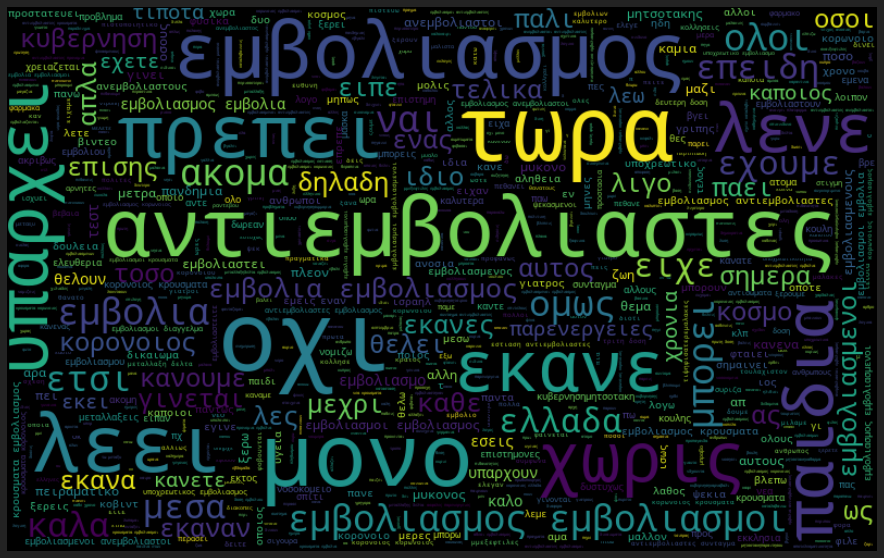

In [43]:
all_words = ' '.join([text for text in df['Tweet_without_stopwords']]) 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500,max_words = 2000,random_state=21,max_font_size=90).generate(all_words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [57]:
#inpecting all the words in our dataframe
all_words

'λενε καθηγητες ωρλ ανεμβολιαστα ζωα πεθαινουν κορωνοιο εμβολιασμενα ζωα πεθαινουν κορωνοιο συμπερασμα υπαρχει ζωο οργανισμος ζωικα κυτταρα οποια κορωνοιος στοχους δυστυχως δεδομενα αλλαζουν ειτε αρεσει ειτε οχι θες προβλημα θελεις πιστεψεις δεδομενα επειδη ετσι καπνισε προβληματικο σορρυ υπαρχει χειροκροτουν πυροσβεστες μεχρι σβησει φωτια καταρες απειλες απολυσης εχετε μισο λεπτο μιλησω μητσοτακηγαμιεσαι μητσοτακηπαραιτησου μητσοτακηκαθαρμα φωτι… σκεψου ιδιοι εμπιστευονται ημαρτον ξεστραβωθειτε πιτσιρικαδες ασχημο κολλημα εγκεφαλικη σκατιλα τοσο νεαροι μαντεψε υπερβλακιτους πολλαπλασιους σημερινων ηρθε ελλαδα ποιοο θαρραλεοι κανανε εχετε μισο λεπτο μιλησω μητσοτακηγαμιεσαι μητσοτακηπαραιτησου μητσοτακηκαθαρμα φωτιες αναμενεται εξασφαλισει πληρη εγκριση αρχες σεπτεμβριου δηλαδη σταση γιατρος ολες μπαρουφες ανεβαζει αγορι πανηγυρια πιθανοτητα παθει καποιος μικροτερη παθει κοβιντ ακομα παιδια λενε δεδομενα ανοχη ψεκια τελος μορφωσου βουλωνε δες επιπλοκες ακομα νεους εργασια σπιτι σημερα 

In [39]:
#Save the new file
# df.to_csv('data/modified_with_length.csv')